# DPLL Implementation

Implementation of the DPLL algorithm with degree heuristics.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import time

In [3]:
class Literal: 
    
    def __init__(self, name, value=True): 
        self.name = name
        self.value = value

#     def __str__(self):
        
#         return str(self.name)
    
#     def __repr__(self):

#         if self.value: 
#             return self.name
#         else: 
#             return "-" + self.name
        
    def __hash__(self):

        return(hash(self.name))
    
    @property
    def negative_literal(self): 

        return Literal(name = self.name, value = not self.value)
    
    def __neg__(self):
        return self.negative_literal

In [28]:
N = Literal('N')
neg_N = -N
print(N)
print(neg_N)
(-N).value = True
print(N)
print(neg_N)



In [146]:
class Literal: 
    
    def __init__(self, name, value=True): 
        self.name = name
        self.value = value

    def __str__(self):
        
        return str(self.name)
    
    def __repr__(self):

        if self.value: 
            return self.name
        else: 
            return "-" + self.name
        
    def __hash__(self):

        return(hash(self.name))
    
    @property
    def negative_literal(self): 

        return Literal(name = self.name, value = not self.value)
    
    def __neg__(self):
        return self.negative_literal

def get_symbol_org(clauses): 
    '''
    Get the original symbols (literals) inside a set of clause (original here means that
    only symbols with positive signs are returned, and no duplicates will be returned)
    
    Input: 
        clauses (list of sets): the clauses in which we want to extract the symbol from
        
    Output: the set of unique symbols in the clauses
    
    '''
    symbols = []
    symbol_names = list(set([symbol.name for clause in clauses for symbol in clause]))
    for clause in clauses:
        for symbol in clause: 
            if (symbol.name in symbol_names) and (symbol not in symbols): 
                symbols.append(literal_object[literal_name.index(symbol.name)])
                symbol_names.remove(symbol.name)
    return set(symbols)

def model_check(clauses, model):
    '''
    Perform model checking, which is the process of using the assigned values of the symbols 
    given in the model and match it with the clauses to see if they evaluates to False, True or
    undetermined (due to not enough values)
    
    Input: 
        clauses (list of sets): the clauses in which we want to check the model on
        model (dict): the symbols with theirs assigned values, in the form of symbol:value
    
    Output: A value of either True/False corresponding to the evaluation of the clauses, or 
            None if we cannot determine the truth value of the clauses from the information 
            given in the model alone
            
    '''
    #Keeping a global lists of literal objects and literal names for references along the way
    global literal_object, literal_name
    
    #If the model is empty, return None
    if len(model) == 0: 
        return None
    
    #Extracting the free symbols (the unassigned symbols, according to the model)
    model_symbols = set(model.keys())
    clause_symbols = set(literal_object)
    free_symbols = clause_symbols - clause_symbols.intersection(model_symbols)
    free_symbols_names = [symbol.name for symbol in free_symbols] 
    
    #Looping through all the literals and re-assigned their respective values in this model
    for literal in literal_object: 
        if (not (literal in free_symbols)):
            literal_object[literal_name.index(literal.name)].value = model[literal]
            
    #Looping through all the symbols in all the clauses to determine the clause truth value,
    #then the clauses overall truth value
    truth_value = []
    for clause in clauses: 
        clause_value = []
        for symbol in clause:
            if (not (symbol.name in free_symbols_names)):
                if (symbol == literal_object[literal_name.index(symbol.name)]):
                    clause_value.append(literal_object[literal_name.index(symbol.name)].value)
                elif (not (symbol == literal_object[literal_name.index(symbol.name)])):
                    clause_value.append(not literal_object[literal_name.index(symbol.name)].value)
            else:
                clause_value.append('free')
        #Determining the truth value of a single clause
        if True in clause_value: 
            truth_value.append(True)
            continue
        elif 'free' in clause_value: 
            truth_value.append('undetermined')
            continue
        else: 
            truth_value.append(False)
            
    #Determining the truth value of all the clause combined
    if False in truth_value: 
        return False
    elif 'undetermined' in truth_value: 
        return None
    else: 
        return True
def DPLL(clauses, symbols, model, degree_h = True):
    '''
    Perform the DPLL algorithm on a set of clauses, symbols and a model
    
    Input: 
        clauses (list of sets): the clauses in which we want to perform the DPLL algorithm on
        symbols (set): the set of symbols remain unassigned, up to this point
        model (dict): the symbols with theirs assigned values, in the form of symbol:value
        degree_h (bool): whether to use the degree heuristics, default is True
    
    Output: A boolean indicating whether the clauses are satisfiable or not
            
    '''
    #Keeping a global list of literal names and objects for reference
    #also keeping the sorted_list, which is the list of literal objects in
    #the order of their appearances in the clauses, and working_model, which is a 
    #dictionary of a working model (if the clauses are satisfiable)
    global literal_object, literal_name, working_model, sorted_list
    
    #Checking the model 
    check = model_check(clauses, model)
    if check == True:
        working_model = model
        return True
    if check == False:
        return False
    
    if len(symbols) == 0: 
        return False
    #Cheking whether we want to use the degree heuristics or not
    if degree_h: 
        pop_symbol, rest_symbols = degree_heuristics(symbols)
    else:
        pop_symbol = symbols.pop()
        rest_symbols = symbols.copy()
        
    #Assigning a value for the chosen symbol, then call the algorithm recursively
    model_1 = model.copy()
    model_2 = model.copy()
    model_1[(pop_symbol)] = False
    model_2[(pop_symbol)] = True
    
    return (DPLL(clauses, rest_symbols, model_1, degree_h = degree_h) or\
           DPLL(clauses, rest_symbols, model_2, degree_h = degree_h))

def DPLLSatisfiable(KB, degree_h = True):
    '''
    Perform the DPLLSatisfiable algorithm
    
    Input: 
        KB (list of sets): the KB in which we want to perform the algorithm on
        degree_h (bool): whether to use the degree heuristics, default is True
    
    Output: 
        satisfiable (bool): whether the KB is satisfiable or not
        model (dict): a model in which the KB is satisfied in the form of list of symbol:value
                      (symbol:'free' for the free symbols), {} if the KB is not satisfiable       
    '''
    global literal_object, literal_name, working_model, sorted_list
    
    #Extracting the clauses and symbols from the KB
    clauses = [clause for clause in KB]
    symbols = get_symbol_org(clauses)
    
    satisfiable = DPLL(clauses, symbols, {}, degree_h = degree_h)
    if not satisfiable: 
        model = {}
    else: 
        model = parse_model(working_model)
        
    return (satisfiable, model)

def parse_model(model): 
    '''
    Parse a model to make all the missing literals 'free'
    
    Input: a model (dict)
    
    Output: a model (dict), with all the symbols and theirs assigned values of
            the input, plus the 'free' symbols missing from the input
    
    '''
    
    global literal_object, literal_name
    
    parsed = dict([])
    for literal in model.keys():
        parsed[literal.name] = literal.value
    
    for literal in  literal_object: 
        if (not (literal in model.keys())):
            parsed[literal.name] = 'free'
    
    return parsed

def sort_literal(KB):
    '''
    Sort the literal in the order of their appearances in the KB
    
    Input: KB (list of sets)
    
    Output: a list of ordered literal names, from min to max, of their appearances
    
    '''
    ordered = {}
    for name in literal_name:
        ordered[name] = 0

    clause_symbols = [symbol for clause in KB for symbol in clause]
    for symbol in clause_symbols:
        ordered[symbol.name] +=1
        
    sorted_x = sorted(ordered.items(), key=operator.itemgetter(1))
    sorted_list = [item[0] for item in sorted_x]
    return sorted_list

def degree_heuristics(current_symbols):
    '''
    The degree heuristic
    
    Input: current_symbols (set), which is a set of symbols currently unassigned
    
    Output: 
        item (literal): the literal with the most appearances, among the list of the current symbols
        current_symbols (set): the current symbols, after removing the most frequent literal, to pass on
    
    ''' 
    global sorted_list
    symbol_name = sorted_list.pop(-1)
    for item in current_symbols: 
        if item.name == symbol_name:
            result = item
            current_symbols.remove(item)
            return item, current_symbols

Testing the algorithm in the toy example given in the assignment instructions

In [147]:
#Toy example

A = Literal('A')
B = Literal('B')
C = Literal('C')
D = Literal('D')
literal_object = [A, B, C, D]
literal_name = [literal.name for literal in literal_object]
working_model = []
KB = [{A,B},{A,-C},{-A,B,D}]
sorted_list = sort_literal(KB)

DPLLSatisfiable(KB)

(True, {'A': False, 'B': True, 'D': False, 'C': False})

Here we can see that the KB is satisfiable (as expected), and using the degree heuristics the algorithm was actually able to find a more general satisfiable case, which is when A = True, B = True and both C and D are free, instead of when not applying the degree heuristics where the algorithm usually bind a value to C. Sanity checks tell us that when A = True the first and second disjunction {A, B} and {A, -C} are True, and when B = True the last disjunction {-A, B, D} is True. Thus, the algorithm converge to a working model that makes the KB satisfiable.

# Testing The Algorithm With Exercise 7.20

We can convert the following sentences into CNF

S1:A ⇔ (B ∨ E), which can be expressed as S1: (-A ∨ B ∨ E) ∧ (A ∨ -B) ∧ (A ∨ -E)

S2: E ⇒ D, which can be expressed as S2: (-E ∨ D)

S3: C ∧ F ⇒ ¬B, which can be expressed as S3: (-C ∨ -F ∨ -B)

S4: E ⇒ B, which can be expressed as S4: (-E ∨ B)

S5: B ⇒ F, which can be expressed as S5: (-B ∨ F)

S6: B ⇒ C, which can be expressed as S6: (-B ∨ C)   

In [148]:
#Setting up for the DPLL

A = Literal('A')
B = Literal('B')
C = Literal('C')
D = Literal('D')
E = Literal('E')
F = Literal('F')

literal_object = [A, B, C, D, E, F]
literal_name = [literal.name for literal in literal_object]

working_model = []

KB = [{-A, B, E}, {A, -B}, {A, -E}, {-E, D}, {-C, -F, -B}, {-E, B}, {-B, F}, {-B, C}]
sorted_list = sort_literal(KB)


DPLLSatisfiable(KB)

(True,
 {'B': False, 'E': False, 'A': False, 'C': 'free', 'D': 'free', 'F': 'free'})

So the given KB is not satisifable.

# Improvement By The Degree Heuristics

In [152]:
from scipy.stats import binom


def generate_random_KB(num_literal, num_clause): 
    '''
    Generate a random KB with some number of literal and clause, in which the literal appearances are 
    binomially distributed (some literals appear more frequent than the others)
    
    Input:
        num_literal (int): the number of literal to create the KB from
        num_clause (int): the number of clause to create the KB from
        
    Output: 
        KB (list of sets): the generated KB
        literal_object (list): the list of literals in the KB
        literal_name (list): the list of literal names in the KB
    
    '''
    
    #Create a list of random literals
    literal_object = []
    for _ in range(num_literal): 
        literal_object.append(Literal('{}'.format(_)))
    
    literal_name = [literal.name for literal in literal_object]
    
    #Calculating the appearance probability of the literals 
    p = [binom(n=num_literal, p=0.2).pmf(int(name)) for name in literal_name[:-1]]
    p.append((1-np.sum(p)))
    
    #Creating the KB
    KB = []
    for _ in range(num_clause): 
        #Each clause has a random number of literal in it
        num_literal_in_clause = np.random.choice(range(1, num_literal))
        #The literal in each clause is then randomly chosen, based on their appearance probabilities
        chosen_literals = np.random.choice(literal_object, size=num_literal_in_clause, p=p, replace=False)
        clause = []
        for literal in chosen_literals: 
            #Randomly flip the sign of the literal, with p = 0.5
            if np.random.uniform() < 0.5: 
                clause.append(literal)
            else:
                clause.append(-literal)
        if len(clause) > 0:
            KB.append(set(clause))
    
    return KB, literal_object, literal_name


In [158]:
#Scaling with number of clause

average_times_w_deg, average_times_wt_deg = [], []
for num_clause in range(10, 100): 
    times_wt_deg = []
    times_w_deg = []
    for _ in range(10):
        KB, literal_object, literal_name = generate_random_KB(20, num_clause)
        sorted_list = sort_literal(KB)
        start_wt_deg = time.time()
        DPLLSatisfiable(KB, degree_h = False)
        times_wt_deg.append(time.time() - start_wt_deg)
        
        KB, literal_object, literal_name = generate_random_KB(20, num_clause)
        sorted_list = sort_literal(KB)
        start_w_deg = time.time()
        DPLLSatisfiable(KB)
        times_w_deg.append(time.time() - start_w_deg)
    average_times_w_deg.append(np.mean(times_w_deg))
    average_times_wt_deg.append(np.mean(times_wt_deg))

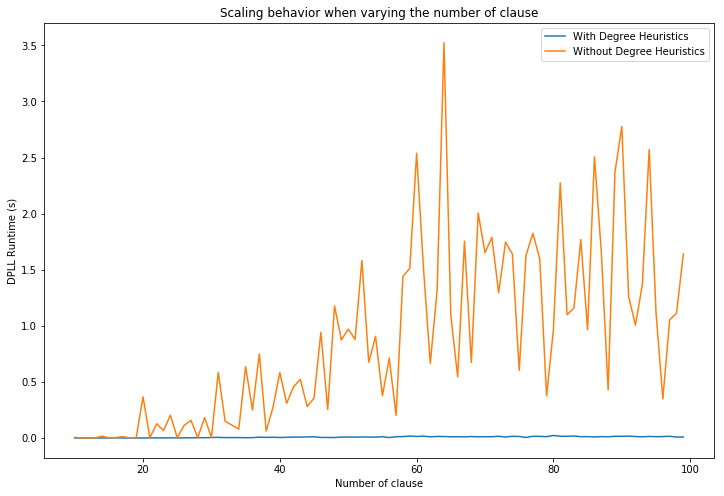

In [159]:
plt.figure(figsize=(12,8))
plt.plot(range(10, 100), average_times_w_deg, label='With Degree Heuristics')
plt.plot(range(10, 100), average_times_wt_deg, label='Without Degree Heuristics')
plt.xlabel('Number of clause')
plt.ylabel('DPLL Runtime (s)')
plt.title('Scaling behavior when varying the number of clause')
plt.legend()
plt.show()

In [160]:
#Scaling with number of literal

average_times_w_deg, average_times_wt_deg = [], []
for num_literal in range(10, 100): 
    times_wt_deg = []
    times_w_deg = []
    for _ in range(10):
        KB, literal_object, literal_name = generate_random_KB(num_literal, 20)
        sorted_list = sort_literal(KB)
        start_wt_deg = time.time()
        DPLLSatisfiable(KB, degree_h = False)
        times_wt_deg.append(time.time() - start_wt_deg)
        
        KB, literal_object, literal_name = generate_random_KB(num_literal, 20)
        sorted_list = sort_literal(KB)
        start_w_deg = time.time()
        DPLLSatisfiable(KB)
        times_w_deg.append(time.time() - start_w_deg)
    average_times_w_deg.append(np.mean(times_w_deg))
    average_times_wt_deg.append(np.mean(times_wt_deg))

ValueError: probabilities are not non-negative

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(range(10, 100), average_times_w_deg, label='With Degree Heuristics')
plt.plot(range(10, 100), average_times_wt_deg, label='Without Degree Heuristics')
plt.xlabel('Number of literal')
plt.ylabel('DPLL Runtime (s)')
plt.title('Scaling behavior when varying the number of literal')
plt.legend()
plt.show()